In [1]:
import pandas as pd
from lifelines import KaplanMeierFitter
import numpy as np
import os
import matplotlib.pyplot as plt




In [2]:
# ensure results folder exists
os.makedirs("data/censoring_methods", exist_ok=True)

# load synthetic data
df = pd.read_csv("C:\\Users\\04ama\\OneDrive\\pension survival analysis\\data\\synthetic_survival_data.csv")

print("Censoring rate:", 1 - df["event_observed"].mean())
df.head()

Censoring rate: 0.33640000000000003


,id,age_at_entry,income_level,health_score,pension_contrib_rate,true_event_time,censor_time,time_to_event,event_observed
0,1,53,36794.48,78.4,0.052,8.653,25.000,8.653,1
1,2,39,45557.62,62.0,0.072,32.314,25.000,25.000,0
2,3,32,35686.13,52.1,0.048,19.388,1.635,1.635,0
3,4,45,70045.55,75.5,0.080,34.158,12.475,12.475,0
4,5,43,49361.51,86.3,0.054,15.370,6.202,6.202,0


In [3]:
df_zero = df.copy()
df_zero["method"] = "zero"
df_zero.to_csv("data/censoring_methods/data_zero.csv", index=False)
print("Saved:", "data/censoring_methods/data_zero.csv")


Saved: data/censoring_methods/data_zero.csv


In [4]:
df_discard = df[df["event_observed"] == 1].copy()
df_discard["method"] = "discard"
df_discard.to_csv("data/censoring_methods/data_discard.csv", index=False)
print("Saved:", "data/censoring_methods/data_discard.csv")


Saved: data/censoring_methods/data_discard.csv


In [5]:
km_c = KaplanMeierFitter()
km_c.fit(
    durations=df["time_to_event"],
    event_observed=1 - df["event_observed"]  # flip: 1=censored
)

# estimated probability of NOT being censored at each observed time
G_hat = km_c.survival_function_at_times(df["time_to_event"]).values

# inverse probability of censoring weights
ipcw = 1 / np.clip(G_hat, 1e-4, None)
ipcw = ipcw / ipcw.mean()  # stabilise mean≈1
df_ipcw = df.assign(ipcw=ipcw)

# censored patients get weight=0
df_ipcw.loc[df_ipcw["event_observed"] == 0, "ipcw"] = 0
df_ipcw["method"] = "ipcw"

df_ipcw.to_csv("data/censoring_methods/data_ipcw.csv", index=False)
print("Saved:", "data/censoring_methods/data_ipcw.csv")


Saved: data/censoring_methods/data_ipcw.csv


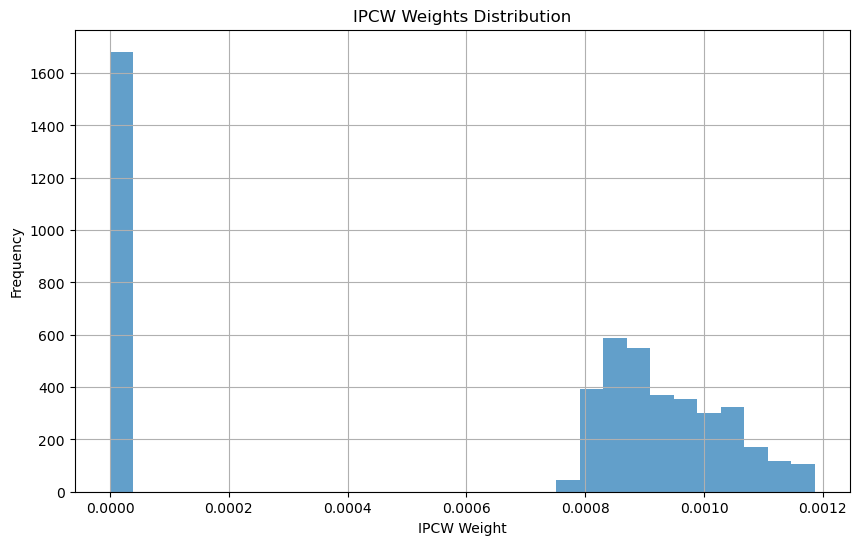

In [6]:
#visualise the weights for ipcw method
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_ipcw["ipcw"], bins=30, alpha=0.7)
plt.title("IPCW Weights Distribution")
plt.xlabel("IPCW Weight")
plt.ylabel("Frequency")
plt.grid()
plt.show()


In [7]:
summary = pd.DataFrame({
    "Method": ["zero", "discard", "ipcw"],
    "Rows": [len(df_zero), len(df_discard), len(df_ipcw)],
    "Censoring rate": [
        1 - df_zero["event_observed"].mean(),
        1 - df_discard["event_observed"].mean(),
        1 - df_ipcw["event_observed"].mean()
    ]
})
summary

summary.to_csv("data/censoring_methods/summary_overview.csv", index=False)
print("Saved:", "data/censoring_methods/summary_overview.csv")


Saved: data/censoring_methods/summary_overview.csv
